## Importing libraries

In [180]:
import pandas as pd
import gzip
import csv
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy 
import dateutil
from IPython.core.display import display, HTML
import os

import pylab

from IPython.display import display
from scipy import optimize

## Read CSV file

In [181]:
%%time
df = pd.read_csv('example_dataset.csv',sep=',\s+', delimiter=',', encoding="utf-8", skipinitialspace=True)

Wall time: 389 ms


In [182]:
# show all headers
df.columns

Index(['nm_bedrooms', 'ceiling_fan', 'clothes_dryer', 'clothes_washer',
       'cooking_range', 'cool_stpnt', 'cool_stpnt_ofst_mag',
       'cool_stpnt_ofst_prd', 'dish_washer', 'ducts', 'nm_floors',
       'foundation', 'garage', 'house_size', 'heating_fuel', 'heat_stpnt',
       'heat_stpnt_ofst_mag', 'heat_stpnt_ofst_prd', 'hot_water_distribution',
       'cool_efficiency', 'cool_type', 'heat_pump', 'heat_electricity',
       'heat_natural_gas', 'heat_propane', 'is_heat_pump', 'infiltration',
       'insulation_crawlspace', 'insulation_finished_basement',
       'insulation_finished_roof', 'insulation_interzonal_floor',
       'insulation_slab', 'insulation_unfinished_attic',
       'insulation_unfinished_basement', 'insulation_wall', 'lighting',
       'location', 'extra_refrigerator', 'freezer', 'gas_fireplace', 'hot_tub',
       'pool', 'well_pump', 'neighbors', 'orientation', 'plug_loads',
       'pool_heater', 'pool_pump', 'refrigerator', 'roof_material', 'vintage',
       'wat

## Select specific variables from data set

In [183]:

df = df[[ 'nm_bedrooms', 'house_size',#'ceiling_fan', 'clothes_dryer', 'clothes_washer',
         #'cooking_range', 'cool_stpnt', 'cool_stpnt_ofst_mag',
        #'cool_stpnt_ofst_prd', 'dish_washer', 'ducts', 'nm_floors',
         #'foundation', 'garage', 'house_size', 'heating_fuel', 'heat_stpnt',
         #'heat_stpnt_ofst_mag', 'heat_stpnt_ofst_prd', 'hot_water_distribution',
         #'cool_efficiency', 'cool_type', 'heat_pump', 'heat_electricity',
         #'heat_natural_gas', 'heat_propane', 'is_heat_pump', 'infiltration', 
         #'lighting','location', 'extra_refrigerator', 'freezer', 'gas_fireplace', 'hot_tub',
         #'pool','well_pump', 'neighbors',
         #'pool_heater', 'pool_pump', 'refrigerator', 'roof_material', 'vintage',
         #'water_heater', 'windows',
         'total_site_energy' ]]

df.head(5)

,nm_bedrooms,house_size,total_site_energy
0,2.0,1500-2499_LA,48.623018
1,3.0,0-1499_LA,38.585635
2,2.0,0-1499_LA,29.628763
3,3.0,0-1499_LA,35.808531
4,3.0,1500-2499_LA,70.214292


## Method to update distriubtion based on new mean and variance

In [184]:

def newWeightOptimization(oldWeights,vals,newMean,numberOfMoments):
    #recommended Number of moments = len(oldWeights)
    numberOfMoments = len(oldWeights)
    oldMean = 0
    for i in range(len(oldWeights)):
        oldMean += oldWeights[i]*vals[i]
    
    #calculate moments:
    moments = np.zeros(numberOfMoments)
    for i in range(numberOfMoments):
        for j in range(len(oldWeights)):
            moments[i]+=oldWeights[j]*((vals[j]-oldMean)**(i+2))
    
    bounds = []
    for i in range(len(oldWeights)):
        bounds.append((0,1))
    bounds = tuple(bounds)
    
    constraints = [{'type':'eq', 'fun':lambda x:np.sum(x)-1},{'type':'eq','fun':lambda x: np.dot(x,vals)-newMean}]
    
    def _func(x):
        
        Xmatrix = np.zeros((numberOfMoments,len(oldWeights)))

        for i in range(numberOfMoments):
            for j in range(len(oldWeights)):
                Xmatrix[i,j] = (vals[j]-newMean)**(i+2)
                
        Xmatrix /= np.linalg.norm(Xmatrix)
        #Xmatrix*=100
        objective = 0
        for i in range(numberOfMoments):
            objective += ((.5)*i)*(Xmatrix[i,:].dot(x))**2
        
        #optional regularization:
        
#         for i in range(len(x)):
#             objective += newMean*x[i]*np.log(x[i])
            
        return objective
    x0 = np.random.rand(len(oldWeights))
    x0/=sum(x0)
    res = optimize.minimize(_func,x0,bounds=bounds,constraints=constraints)
    
    return res.x
                


def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))


## 1- Adding sample distribution columns to dataset

In [185]:
%%time

# get lenght of dataframe
N = float(len(df))

# get distributions 
for c in df.columns:  
        if c == 'total_site_energy' or c == 'weight':
            continue
        print(f"Processing {c}")
        counts = df[c].value_counts()
        
        # find distributions and add distribution columns to dataframe
        df[c+'_dist'] = df[c].map(lambda x: counts.loc[x]) / N


Processing nm_bedrooms
Processing house_size
Wall time: 1.29 s


In [186]:
# resulting dataframe
df.head()

,nm_bedrooms,house_size,total_site_energy,nm_bedrooms_dist,house_size_dist
0,2.0,1500-2499_LA,48.623018,0.618445,0.351943
1,3.0,0-1499_LA,38.585635,0.255266,0.491407
2,2.0,0-1499_LA,29.628763,0.618445,0.491407
3,3.0,0-1499_LA,35.808531,0.255266,0.491407
4,3.0,1500-2499_LA,70.214292,0.255266,0.351943


# 2- Adding target distributions to data set

In [187]:
# decide what variable you want to change ( ex. set a new target distribution for number of bedrooms)
# find what is the mean of this variable and what would be your target mean
df.nm_bedrooms.mean()

2.3933198202167976

In [188]:
%%time
# generate target distributions
for c in df.columns:  
    
        if '_dist' not in c and '_target' not in c and 'site_energy' not in c and 'weight' not in c:
            
            print(f"*************Processing {c}**************")
            # zip variables and distributions
            z = dict(zip(df[c],df[c+'_dist']))
            print (f"old_dist = {z}")

            ### set inputs to weightConverion method
            #set vals
            vals = np.array(list(z.keys()))
            #set oldDist
            oldDist = np.array(list(z.values()))
            #set targeted means of each variable distribution that is going to change
            if c == 'nm_bedrooms':
                newMean = 3
            #for non changing variables the target distribution will be same as the original distribution
            else: 
                print (f"new_dist = {z}")
                df[c+'_target'] = df[c+'_dist']
                continue
                
            numberOfMoments = 3

            # find target distributions(weights) for each variable that have a new target mean
            w = newWeightOptimization(oldDist,vals,newMean,numberOfMoments)
            # output new distributions as a list
            w = w.tolist()
            
            #zip weight and values
            new_dist = dict(zip(vals,w))
            print(f"new_dist = {new_dist}")

            # layout target distribution in data frame
            y=[]
            for x in df[c]:
                y.append(new_dist[x])

            df[c+'_target'] = y

*************Processing nm_bedrooms**************
old_dist = {2.0: 0.6184454040715608, 3.0: 0.255265708997973, 1.0: 0.04498986516259804, 5.0: 0.012646514497223937, 4.0: 0.0651714109456244, 6.0: 0.0026438706265973387, 7.0: 0.0008372256984224906}
new_dist = {2.0: 0.13317772925192092, 3.0: 0.24394081926750583, 1.0: 0.21684623207329948, 5.0: 0.16083497399124735, 4.0: 0.2452002454160262, 6.0: 0.0, 7.0: 5.551115123125783e-17}
*************Processing house_size**************
old_dist = {'1500-2499_LA': 0.35194324491054907, '0-1499_LA': 0.4914074204635587, '3500+_LA': 0.053979025293029, '2500-3499_LA': 0.10267030933286331}
new_dist = {'1500-2499_LA': 0.35194324491054907, '0-1499_LA': 0.4914074204635587, '3500+_LA': 0.053979025293029, '2500-3499_LA': 0.10267030933286331}
Wall time: 36.2 ms


In [189]:
#resulting dataframe
pd.set_option('display.max_columns', 100)
df.head()

,nm_bedrooms,house_size,total_site_energy,nm_bedrooms_dist,house_size_dist,nm_bedrooms_target,house_size_target
0,2.0,1500-2499_LA,48.623018,0.618445,0.351943,0.133178,0.351943
1,3.0,0-1499_LA,38.585635,0.255266,0.491407,0.243941,0.491407
2,2.0,0-1499_LA,29.628763,0.618445,0.491407,0.133178,0.491407
3,3.0,0-1499_LA,35.808531,0.255266,0.491407,0.243941,0.491407
4,3.0,1500-2499_LA,70.214292,0.255266,0.351943,0.243941,0.351943


## 3- Applying weighting method

In [190]:
%%time
#add Weight column to data frame (note that this weight column is for the whole dataframe and not for each column)
# the all the Weights are intialized to be 1 as a start
df["weight"] = 1 

# Set Solving tolerance
tol=1e-5

# Initialize delta weight
delta_w_norm = 1.0/tol


Wall time: 992 µs


In [191]:
#resulting dataframe
df.head()

,nm_bedrooms,house_size,total_site_energy,nm_bedrooms_dist,house_size_dist,nm_bedrooms_target,house_size_target,weight
0,2.0,1500-2499_LA,48.623018,0.618445,0.351943,0.133178,0.351943,1
1,3.0,0-1499_LA,38.585635,0.255266,0.491407,0.243941,0.491407,1
2,2.0,0-1499_LA,29.628763,0.618445,0.491407,0.133178,0.491407,1
3,3.0,0-1499_LA,35.808531,0.255266,0.491407,0.243941,0.491407,1
4,3.0,1500-2499_LA,70.214292,0.255266,0.351943,0.243941,0.351943,1


### running weighting method

********processing nm_bedrooms***********
********processing house_size***********
NORM DELTA_W ==== 0.012012902536123148
********processing nm_bedrooms***********
********processing house_size***********
NORM DELTA_W ==== 0.007154362780781536
********processing nm_bedrooms***********
********processing house_size***********
NORM DELTA_W ==== 0.0


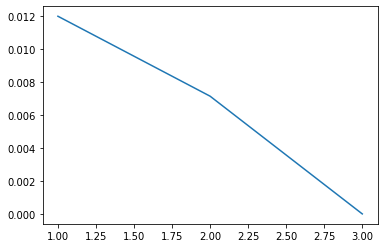

In [192]:
#%%time
# initialize number of itterations
count = 0
itterations = []
# initialize delta_w list 
delta_w_list = []

#initilize total weight
tW = df.weight.sum()

# while the delta weigth norm is less than the tolerance
while delta_w_norm > tol:
    
    # get w_old
    w_old = df['weight']  
    
    # add number of itterations to a list
    count += 1
    itterations.append(count)
    
    
    #change original distributions
    #distribution = weight for a corresponing categroy of a variable / tW 
    for c in df.columns:

        if 'total_site_energy' not in c and 'weight' not in c and '_dist' not in c and '_target' not in c and '_weight' not in c:

            print (f"********processing {c}***********")   
            a = df[[c , 'weight']].groupby(c, as_index = False ).sum()
            dict_a = dict(zip(a[c], a['weight']))          
            df[c+'_dist'] = df[c].map(lambda x: dict_a[x]/tW)
            
    
    
    #apply reweighting
    for c in df.columns:
        
        if 'total_site_energy' not in c and 'weight' not in c and '_dist' not in c and '_target' not in c and '_weight' not in c:

            # find weights for each variable
            #new weight = target distribution / sample distribution
            #df[c+'_weight'] = df[c+'_target'] / df[c+'_dist']                     

            # multiple by main weight column
            #df['weight'] =  df['weight'] * df[c+'_weight']
            
            #both steps in 1
            df['weight'] = (df[c+'_target'] / df[c+'_dist']) * df['weight']


    # find new weight of output; w_new
    w_new = df['weight']
    #print (f"NEW WEIGHT COLUMN IS === {w_new}")
    #print (f"OLD WEIGHT COLUMN IS === {w_old}")
    #print (f"w_new = {w_new.head()}")
    
    # find delta weight
    delta_w = np.abs(w_old - w_new)
    
    #delta_w_max = delta_w.max()
    delta_w_norm = np.sqrt(np.sum(np.power(delta_w,2.0)))/float(len(delta_w))
    
    #print ("*****************************************************************")
    print(f"NORM DELTA_W ==== {delta_w_norm}")
    #print(f"MAX DELTA_W ==== {delta_w_max}")
    #print ("*****************************************************************")

    # put delta_w in a list 
    delta_w_list.append(delta_w_norm)

plt.plot(itterations, delta_w_list)

In [193]:
df.head()

,nm_bedrooms,house_size,total_site_energy,nm_bedrooms_dist,house_size_dist,nm_bedrooms_target,house_size_target,weight
0,2.0,1500-2499_LA,48.623018,0.175051,0.351943,0.133178,0.351943,0.217184
1,3.0,0-1499_LA,38.585635,0.269650,0.491407,0.243941,0.491407,1.181274
2,2.0,0-1499_LA,29.628763,0.175051,0.491407,0.133178,0.491407,0.223858
3,3.0,0-1499_LA,35.808531,0.269650,0.491407,0.243941,0.491407,1.181274
4,3.0,1500-2499_LA,70.214292,0.269650,0.351943,0.243941,0.351943,1.146058


# Visualize results

In [194]:
#len(itterations)

In [195]:
#len(delta_w_list)

In [196]:
#del itterations[-1]

In [197]:
#len(itterations)

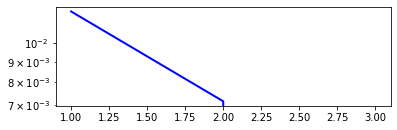

In [198]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

ax.plot(itterations, delta_w_list, color='blue', lw=2)

ax.set_yscale('log')

pylab.show()

In [495]:
print(delta_w_list)
print(itterations)

[nan]
[1]
